In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

FIGURES_DIR = ARTIFACTS_DIR / "figures"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

LABELS_DIR = ARTIFACTS_DIR / "labels"
LABELS_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
# KMeans
def eval_kmeans_grid(X_feat, ks):
    results = []
    for k in ks:
        try:
            model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto")
        except TypeError:
            model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)

        labels = model.fit_predict(X_feat)
        metrics = safe_cluster_metrics(X_feat, labels)

        results.append({
            "algo": "kmeans",
            "params": {"k": k},
            "labels": labels,
            "metrics": metrics,
            "inertia": float(model.inertia_),
            "n_clusters": len(np.unique(labels)),
            "noise_frac": 0.0,
        })
    return results

# DBSCAN
def eval_dbscan_grid(X_feat, eps_list, min_samples_list):
    results = []
    n = len(X_feat)

    for eps in eps_list:
        for ms in min_samples_list:
            model = DBSCAN(eps=eps, min_samples=ms)
            labels = model.fit_predict(X_feat)

            noise_frac = float(np.mean(labels == -1))
            # Метрики по non-noise
            mask = labels != -1
            labels_nn = labels[mask]
            X_nn = X_feat[mask]

            # Перенумеруем метки non-noise, чтобы метрики работали корректнее (не обязательно, но аккуратно)
            if len(labels_nn) > 0:
                uniq = np.unique(labels_nn)
                mapping = {u: i for i, u in enumerate(uniq)}
                labels_nn = np.array([mapping[v] for v in labels_nn], dtype=int)

            metrics = None
            n_clusters = 0
            if len(X_nn) >= 10 and len(np.unique(labels_nn)) >= 2:
                metrics = safe_cluster_metrics(X_nn, labels_nn)
                n_clusters = len(np.unique(labels_nn))

            results.append({
                "algo": "dbscan",
                "params": {"eps": float(eps), "min_samples": int(ms)},
                "labels": labels,
                "metrics": metrics,
                "inertia": None,
                "n_clusters": int(n_clusters),
                "noise_frac": float(noise_frac),
                "n_non_noise": int(mask.sum()),
            })
    return results

# Agglomerative
def eval_agglomerative_grid(X_feat, ks, linkages):
    results = []
    for linkage_name in linkages:
        for k in ks:
            try:
                model = AgglomerativeClustering(n_clusters=k, linkage=linkage_name)
                labels = model.fit_predict(X_feat)
            except Exception:
                continue

            metrics = safe_cluster_metrics(X_feat, labels)

            results.append({
                "algo": "agglomerative",
                "params": {"k": int(k), "linkage": linkage_name},
                "labels": labels,
                "metrics": metrics,
                "inertia": None,
                "n_clusters": len(np.unique(labels)),
                "noise_frac": 0.0,
            })
    return results

def pick_best_by_silhouette(results):
    best = None
    best_score = -np.inf
    for r in results:
        m = r["metrics"]
        if m is None:
            continue
        s = m["silhouette"]
        if s is None:
            continue
        if s > best_score:
            best_score = s
            best = r
    return best, best_score


Датасет №1

In [3]:
data = pd.read_csv('S07-hw-dataset-01.csv')
print("Форма X:", data.shape)
print("Названия признаков:", list(data.columns))

display(data.head())
display(data.info())
display(data.describe())
display(data.isna().mean())

X = data.iloc[:, 1:]
display(X.head())
sample_id = data.sample_id
display(sample_id.head())

Форма X: (12000, 9)
Названия признаков: ['sample_id', 'f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07', 'f08']


,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
0,0,-0.536647,-69.812900,-0.002657,71.743147,-11.396498,-12.291287,-6.836847,-0.504094
1,1,15.230731,52.727216,-1.273634,-104.123302,11.589643,34.316967,-49.468873,0.390356
2,2,18.542693,77.317150,-1.321686,-111.946636,10.254346,25.892951,44.595250,0.325893
3,3,-12.538905,-41.709458,0.146474,16.322124,1.391137,2.014316,-39.930582,0.139297
4,4,-6.903056,61.833444,-0.022466,-42.631335,3.107154,-5.471054,7.001149,0.131213


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  float64
 4   f04        12000 non-null  float64
 5   f05        12000 non-null  float64
 6   f06        12000 non-null  float64
 7   f07        12000 non-null  float64
 8   f08        12000 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 843.9 KB


None

,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,5999.50000,-2.424716,19.107804,-0.222063,-8.284501,-0.190717,0.962972,0.033724,0.007638
std,3464.24595,11.014315,60.790338,0.500630,59.269838,7.026435,14.794713,59.541782,0.607053
min,0.00000,-19.912573,-92.892652,-1.590979,-134.303679,-11.869169,-20.521164,-215.098834,-2.633469
25%,2999.75000,-9.472623,-40.282955,-0.125145,-48.345007,-5.132473,-8.807706,-39.900520,-0.401483
50%,5999.50000,-6.869404,54.069335,-0.031753,16.211728,0.444730,-6.134169,-0.578494,0.005306
75%,8999.25000,0.523841,70.280739,0.054980,28.067178,3.942368,2.334426,39.719821,0.410132
max,11999.00000,24.403381,112.229523,0.512277,75.088604,13.717091,41.452857,213.381767,2.490745


,0
sample_id,0.0
f01,0.0
f02,0.0
f03,0.0
f04,0.0
f05,0.0
f06,0.0
f07,0.0
f08,0.0


,f01,f02,f03,f04,f05,f06,f07,f08
0,-0.536647,-69.812900,-0.002657,71.743147,-11.396498,-12.291287,-6.836847,-0.504094
1,15.230731,52.727216,-1.273634,-104.123302,11.589643,34.316967,-49.468873,0.390356
2,18.542693,77.317150,-1.321686,-111.946636,10.254346,25.892951,44.595250,0.325893
3,-12.538905,-41.709458,0.146474,16.322124,1.391137,2.014316,-39.930582,0.139297
4,-6.903056,61.833444,-0.022466,-42.631335,3.107154,-5.471054,7.001149,0.131213


,sample_id
0,0
1,1
2,2
3,3
4,4


Все 8 признаков числовые, пропусков нет, признаки в разных шкалах, необходимо масштабирование.

In [4]:
# - best_metrics: сводка метрик по датасетам и моделям
# - best_configs: какие параметры выбраны как "лучшие" для каждого датасета
best_metrics = []
best_configs = []

Препроцессинг

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca_dim = 8
pca_model = PCA(n_components=pca_dim, random_state=RANDOM_STATE)
X_feat = pca_model.fit_transform(X_scaled)

print("X_scaled.shape:", X_scaled.shape)
print("X_feat.shape:", X_feat.shape)

X_scaled.shape: (12000, 8)
X_feat.shape: (12000, 8)


In [5]:
def safe_cluster_metrics(X, labels):
    """Считает метрики; возвращает None, если метрика неприменима."""
    unique = np.unique(labels)
    # Нужно минимум 2 кластера
    if len(unique) < 2:
        return None

    # Нельзя, чтобы все точки были в одном кластере
    if len(unique) == 1:
        return None

    # silhouette требует, чтобы все кластеры имели >1 точки (часто, но не всегда)
    # В sklearn silhouette_score может падать, если какой-то кластер пуст/особый.
    try:
        sil = float(silhouette_score(X, labels))
    except Exception:
        sil = None

    try:
        db = float(davies_bouldin_score(X, labels))
    except Exception:
        db = None

    try:
        ch = float(calinski_harabasz_score(X, labels))
    except Exception:
        ch = None

    return {"silhouette": sil, "davies_bouldin": db, "calinski_harabasz": ch}

def pca_2d_for_plot(X_scaled, random_state=RANDOM_STATE):
    """PCA(2D) именно для визуализации."""
    p = PCA(n_components=2, random_state=random_state)
    return p.fit_transform(X_scaled)

def plot_2d_embedding(emb2d, labels, title, save_path=None):
    plt.figure(figsize=(7, 5))
    plt.scatter(emb2d[:, 0], emb2d[:, 1], c=labels, s=18)
    plt.title(title)
    plt.xlabel("dim-1")
    plt.ylabel("dim-2")
    plt.grid(True, alpha=0.2)
    if save_path:
      plt.savefig(save_path)
    plt.show()

def summarize_labels(labels):
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique.tolist(), counts.tolist()))


KMeans

In [7]:
# Диапазон K для KMeans
kmeans_ks = list(range(2, 21))

kmeans_results = eval_kmeans_grid(X_feat, kmeans_ks)
len(kmeans_results), kmeans_results[0]["params"], kmeans_results[-1]["params"]

(19, {'k': 2}, {'k': 20})

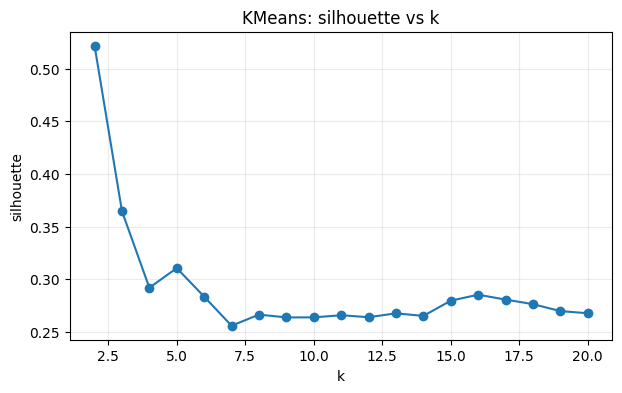

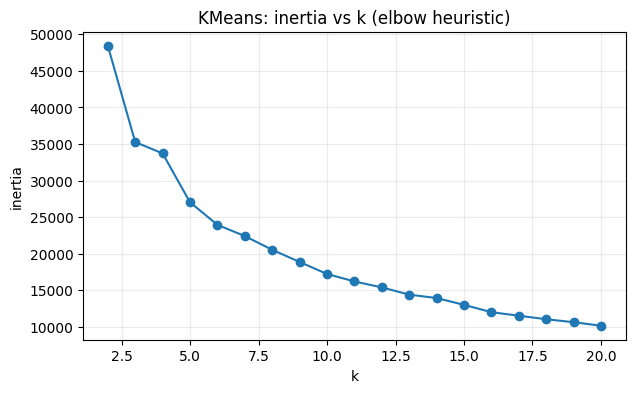

In [8]:
# Быстрый график silhouette по k (если silhouette считалась)
ks = [r["params"]["k"] for r in kmeans_results]
sil = [r["metrics"]["silhouette"] if r["metrics"] else None for r in kmeans_results]

plt.figure(figsize=(7, 4))
plt.plot(ks, sil, marker="o")
plt.title("KMeans: silhouette vs k")
plt.xlabel("k")
plt.ylabel("silhouette")
plt.grid(True, alpha=0.25)
plt.savefig(FIGURES_DIR / "ds1_kmeans_silhouette_vs_k.png")
plt.show()

# Инерция (elbow) – как эвристика
inertia = [r["inertia"] for r in kmeans_results]
plt.figure(figsize=(7, 4))
plt.plot(ks, inertia, marker="o")
plt.title("KMeans: inertia vs k (elbow heuristic)")
plt.xlabel("k")
plt.ylabel("inertia")
plt.grid(True, alpha=0.25)
plt.savefig(FIGURES_DIR / "ds1_kmeans_inertia_vs_k.png")
plt.show()

In [9]:
best_kmeans, best_kmeans_s = pick_best_by_silhouette(kmeans_results)
best_kmeans["params"], round(best_kmeans_s, 3)
best_metrics.append({'dataset1 kmeans': best_kmeans["metrics"]})
best_configs.append({'dataset1 kmeans': best_kmeans["params"]})

DBSCAN

In [10]:
# Сетка для DBSCAN: eps и min_samples
# eps зависит от масштаба данных – после scaling обычно eps ~ 0.5..5 (но это очень примерно).
dbscan_eps = [1.5, 2.0, 2.5, 3.0, 3.5]
dbscan_min_samples = [3, 5, 10]

dbscan_results = eval_dbscan_grid(X_feat, dbscan_eps, dbscan_min_samples)
len(dbscan_results)

15

In [11]:
# Посмотрим, какие варианты вообще дали >=2 кластера (без шума) и посчитали silhouette
valid = [r for r in dbscan_results if r["metrics"] is not None and r["metrics"]["silhouette"] is not None]
print("Valid DBSCAN configs:", len(valid))

# Сортировка по silhouette
valid_sorted = sorted(valid, key=lambda r: r["metrics"]["silhouette"], reverse=True)
for r in valid_sorted[:8]:
    print(r["params"], "sil=", round(r["metrics"]["silhouette"], 3), "noise=", round(r["noise_frac"], 3), "clusters=", r["n_clusters"])


Valid DBSCAN configs: 9
{'eps': 2.0, 'min_samples': 3} sil= 0.522 noise= 0.0 clusters= 2
{'eps': 2.0, 'min_samples': 5} sil= 0.522 noise= 0.0 clusters= 2
{'eps': 2.0, 'min_samples': 10} sil= 0.522 noise= 0.0 clusters= 2
{'eps': 2.5, 'min_samples': 3} sil= 0.522 noise= 0.0 clusters= 2
{'eps': 2.5, 'min_samples': 5} sil= 0.522 noise= 0.0 clusters= 2
{'eps': 2.5, 'min_samples': 10} sil= 0.522 noise= 0.0 clusters= 2
{'eps': 1.5, 'min_samples': 3} sil= 0.397 noise= 0.0 clusters= 3
{'eps': 1.5, 'min_samples': 5} sil= 0.397 noise= 0.0 clusters= 3


In [12]:
best_dbscan = valid_sorted[0] if valid_sorted else None
if best_dbscan:
  print(best_dbscan)

  best_metrics.append({'dataset1 dbscan': best_dbscan["metrics"], "noise_frac": best_dbscan["noise_frac"]})
  best_configs.append({'dataset1 dbscan': best_dbscan["params"]})

{'eps': 2.0, 'min_samples': 3}


Сводка результатов по датасету №1

In [13]:
def print_result_card(name, result):
    m = result["metrics"] or {}
    print("=" * 72)
    print(f"{name}")
    print("algo:", result["algo"])
    print("params:", result["params"])
    print("n_clusters:", result.get("n_clusters"))
    if result["algo"] == "dbscan":
        print("noise_frac:", round(result.get("noise_frac", 0.0), 3), " non-noise:", result.get("n_non_noise"))
    print("metrics:")
    print("  silhouette:", None if m.get("silhouette") is None else round(m["silhouette"], 3))
    print("  davies_bouldin:", None if m.get("davies_bouldin") is None else round(m["davies_bouldin"], 3))
    print("  calinski_harabasz:", None if m.get("calinski_harabasz") is None else round(m["calinski_harabasz"], 1))
    if result.get("inertia") is not None:
        print("  inertia:", round(result["inertia"], 1))

print_result_card("BEST KMEANS (by silhouette)", best_kmeans)
if best_dbscan is not None:
    print_result_card("BEST DBSCAN (by silhouette among valid)", best_dbscan)


BEST KMEANS (by silhouette)
algo: kmeans
params: {'k': 2}
n_clusters: 2
metrics:
  silhouette: 0.522
  davies_bouldin: 0.685
  calinski_harabasz: 11787.0
  inertia: 48425.9
BEST DBSCAN (by silhouette among valid)
algo: dbscan
params: {'eps': 2.0, 'min_samples': 3}
n_clusters: 2
noise_frac: 0.0  non-noise: 12000
metrics:
  silhouette: 0.522
  davies_bouldin: 0.685
  calinski_harabasz: 11787.0


Визуализация выбранных решений в 2D

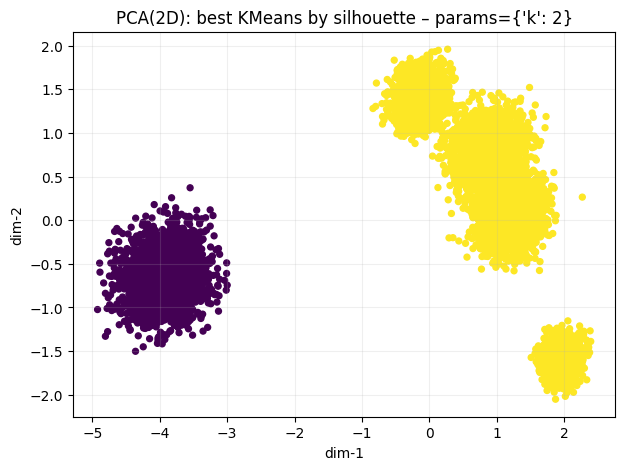

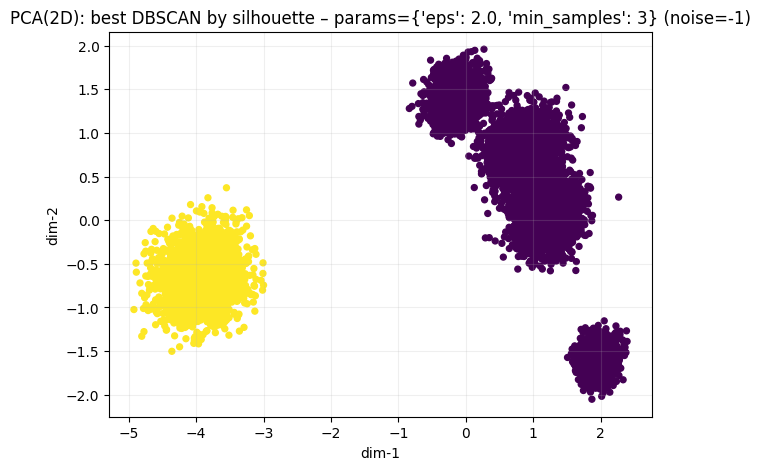

In [14]:
X_plot2d = pca_2d_for_plot(X_scaled, random_state=RANDOM_STATE)

save_path = FIGURES_DIR / "ds1_PCA.png"
# KMeans best
plot_2d_embedding(
    X_plot2d, best_kmeans["labels"],
    title=f"PCA(2D): best KMeans by silhouette – params={best_kmeans['params']}",
    save_path=save_path
)

# DBSCAN best (if exists)
if best_dbscan is not None:
    plot_2d_embedding(
        X_plot2d, best_dbscan["labels"],
        title=f"PCA(2D): best DBSCAN by silhouette – params={best_dbscan['params']} (noise=-1)"
    )

In [15]:
result_df = pd.DataFrame({
    'sample_id': sample_id,
    'cluster_label': best_kmeans['labels']
})

save_label_path = LABELS_DIR / 'labels_ds1.csv'
result_df.to_csv(save_label_path, index=False)

KMeans и DBSCAN сработали одинаково, так как датасет достаточно простой. Оба алгоритма показали идентичное разбиение на 2 класса, также одинаковые метрики.

Датасет №2

In [6]:
data = pd.read_csv('S07-hw-dataset-02.csv')
print("Форма X:", data.shape)
print("Названия признаков:", list(data.columns))

display(data.head())
print(data.info())
print(data.describe())
print(data.isna().mean())

X = data.iloc[:, 1:]
display(X.head())
sample_id = data.sample_id
display(sample_id.head())

Форма X: (8000, 4)
Названия признаков: ['sample_id', 'x1', 'x2', 'z_noise']


,sample_id,x1,x2,z_noise
0,0,0.098849,-1.846034,21.288122
1,1,-1.024516,1.829616,6.072952
2,2,-1.094178,-0.158545,-18.938342
3,3,-1.612808,-1.565844,-11.629462
4,4,1.659901,-2.133292,1.895472


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  8000 non-null   int64  
 1   x1         8000 non-null   float64
 2   x2         8000 non-null   float64
 3   z_noise    8000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 250.1 KB
None
        sample_id           x1           x2      z_noise
count  8000.00000  8000.000000  8000.000000  8000.000000
mean   3999.50000     0.478867     0.241112     0.110454
std    2309.54541     0.955138     0.663195     8.097716
min       0.00000    -2.487352    -2.499237   -34.056074
25%    1999.75000    -0.116516    -0.242357    -5.392210
50%    3999.50000     0.490658     0.241092     0.132470
75%    5999.25000     1.085263     0.726526     5.655605
max    7999.00000     2.987555     2.995553    29.460076
sample_id    0.0
x1           0.0
x2           0.0
z_noise      0.0
dtype: float64


,x1,x2,z_noise
0,0.098849,-1.846034,21.288122
1,-1.024516,1.829616,6.072952
2,-1.094178,-0.158545,-18.938342
3,-1.612808,-1.565844,-11.629462
4,1.659901,-2.133292,1.895472


,sample_id
0,0
1,1
2,2
3,3
4,4


Препроцессинг

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca_dim = 3
pca_model = PCA(n_components=3, random_state=RANDOM_STATE)
X_feat = pca_model.fit_transform(X_scaled)

print("X_scaled.shape:", X_scaled.shape)
print("X_feat.shape:", X_feat.shape)

X_scaled.shape: (8000, 3)
X_feat.shape: (8000, 3)


KMeans

In [18]:
# Диапазон K для KMeans
kmeans_ks = list(range(2, 21))

kmeans_results = eval_kmeans_grid(X_feat, kmeans_ks)
len(kmeans_results), kmeans_results[0]["params"], kmeans_results[-1]["params"]

(19, {'k': 2}, {'k': 20})

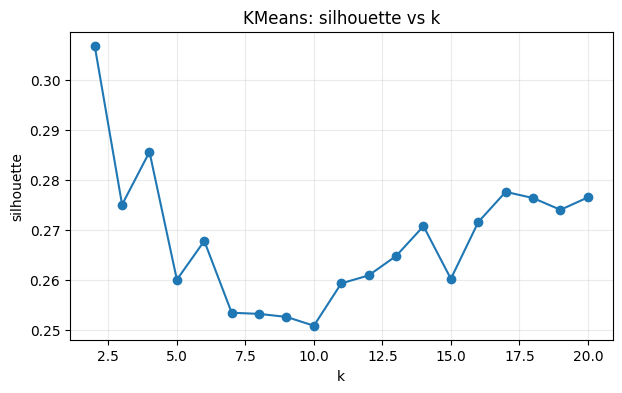

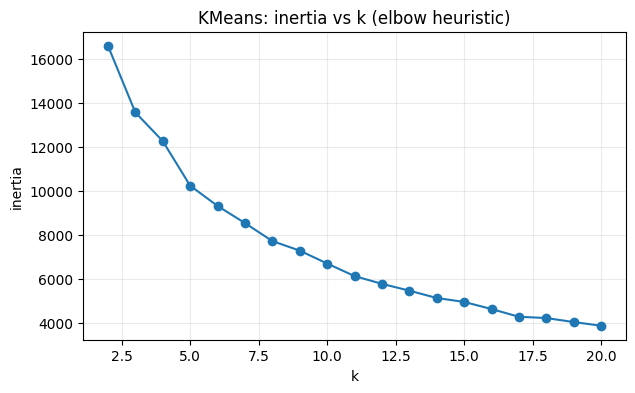

In [19]:
# Быстрый график silhouette по k (если silhouette считалась)
ks = [r["params"]["k"] for r in kmeans_results]
sil = [r["metrics"]["silhouette"] if r["metrics"] else None for r in kmeans_results]

plt.figure(figsize=(7, 4))
plt.plot(ks, sil, marker="o")
plt.title("KMeans: silhouette vs k")
plt.xlabel("k")
plt.ylabel("silhouette")
plt.grid(True, alpha=0.25)
plt.savefig(FIGURES_DIR / "ds2_kmeans_silhouette_vs_k.png")
plt.show()

# Инерция (elbow) – как эвристика
inertia = [r["inertia"] for r in kmeans_results]
plt.figure(figsize=(7, 4))
plt.plot(ks, inertia, marker="o")
plt.title("KMeans: inertia vs k (elbow heuristic)")
plt.xlabel("k")
plt.ylabel("inertia")
plt.grid(True, alpha=0.25)
plt.savefig(FIGURES_DIR / "ds2_kmeans_inertia_vs_k.png")
plt.show()

In [20]:
best_kmeans, best_kmeans_s = pick_best_by_silhouette(kmeans_results)
best_kmeans["params"], round(best_kmeans_s, 3)

best_metrics.append({'dataset2 kmeans': best_kmeans["metrics"]})
best_configs.append({'dataset2 kmeans': best_kmeans["params"]})

DBSCAN

In [8]:
dbscan_eps = [0.001, 0.01, 0.1, 3]
dbscan_min_samples = [3, 5, 10]
dbscan_results = eval_dbscan_grid(X_feat, dbscan_eps, dbscan_min_samples)
len(dbscan_results)

12

In [9]:
# Посмотрим, какие варианты вообще дали >=2 кластера (без шума) и посчитали silhouette
valid = [r for r in dbscan_results if r["metrics"] is not None and r["metrics"]["silhouette"] is not None]
print("Valid DBSCAN configs:", len(valid))

# Сортировка по silhouette
valid_sorted = sorted(valid, key=lambda r: r["metrics"]["silhouette"], reverse=True)
for r in valid_sorted[:8]:
    print(r["params"], "sil=", round(r["metrics"]["silhouette"], 3), "noise=", round(r["noise_frac"], 3), "clusters=", r["n_clusters"])


Valid DBSCAN configs: 3
{'eps': 0.1, 'min_samples': 10} sil= 0.581 noise= 0.918 clusters= 46
{'eps': 0.1, 'min_samples': 5} sil= -0.129 noise= 0.479 clusters= 178
{'eps': 0.1, 'min_samples': 3} sil= -0.408 noise= 0.295 clusters= 246


In [11]:
best_dbscan = valid_sorted[0] if valid_sorted else None
if best_dbscan:
  print(best_dbscan)

  best_metrics.append({'dataset2 dbscan': best_dbscan["metrics"], "noise_frac": best_dbscan["noise_frac"]})
  best_configs.append({'dataset2 dbscan': best_dbscan["params"]})

{'algo': 'dbscan', 'params': {'eps': 0.1, 'min_samples': 3}, 'labels': array([-1, -1, -1, ...,  1,  0,  0]), 'metrics': {'silhouette': -0.4082444492393506, 'davies_bouldin': 0.9155986943658025, 'calinski_harabasz': 41.897643910363236}, 'inertia': None, 'n_clusters': 246, 'noise_frac': 0.295375, 'n_non_noise': 5637}


Сводка результатов по датасету №2

In [37]:
print_result_card("BEST KMEANS (by silhouette)", best_kmeans)
if best_dbscan is not None:
    print_result_card("BEST DBSCAN (by silhouette among valid)", best_dbscan)


BEST KMEANS (by silhouette)
algo: kmeans
params: {'k': 2}
n_clusters: 2
metrics:
  silhouette: 0.307
  davies_bouldin: 1.323
  calinski_harabasz: 3573.4
  inertia: 16588.5
BEST DBSCAN (by silhouette among valid)
algo: dbscan
params: {'eps': 0.1, 'min_samples': 3}
n_clusters: 246
noise_frac: 0.295  non-noise: 5637
metrics:
  silhouette: -0.408
  davies_bouldin: 0.916
  calinski_harabasz: 41.9


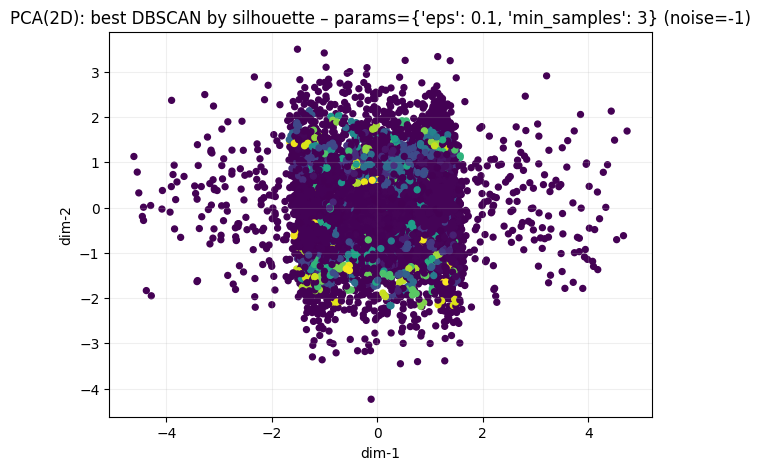

In [14]:
X_plot2d = pca_2d_for_plot(X_scaled, random_state=RANDOM_STATE)

# KMeans best
plot_2d_embedding(
    X_plot2d, best_kmeans["labels"],
    title=f"PCA(2D): best KMeans by silhouette – params={best_kmeans['params']}"
)

# DBSCAN best (if exists)
if best_dbscan is not None:
    plot_2d_embedding(
        X_plot2d, best_dbscan["labels"],
        title=f"PCA(2D): best DBSCAN by silhouette – params={best_dbscan['params']} (noise=-1)"
    )

Подразумевалось по рисунку 3 класса с разной плотностью распределения, KMeans разделил хоть как то пополам, хоть и не освсем верно.
DBSCAN вообще не смог номально выделить кластеры, 99% шумовых точек, слишком много кластеров.

In [ ]:
result_df = pd.DataFrame({
    'sample_id': sample_id,
    'cluster_label': best_kmeans['labels']
})

save_label_path = LABELS_DIR / 'labels_ds2.csv'
result_df.to_csv(save_label_path, index=False)

Датасет №3

In [15]:
data = pd.read_csv('S07-hw-dataset-03.csv')
print("Форма X:", data.shape)
print("Названия признаков:", list(data.columns))

display(data.head())
display(data.info())
display(data.describe())
display(data.isna().mean())

X = data.iloc[:, 1:]
display(X.head())
sample_id = data.sample_id
display(sample_id.head())

Форма X: (15000, 5)
Названия признаков: ['sample_id', 'x1', 'x2', 'f_corr', 'f_noise']


,sample_id,x1,x2,f_corr,f_noise
0,0,-2.710470,4.997107,-1.015703,0.718508
1,1,8.730238,-8.787416,3.953063,-1.105349
2,2,-1.079600,-2.558708,0.976628,-3.605776
3,3,6.854042,1.560181,1.760614,-1.230946
4,4,9.963812,-8.869921,2.966583,0.915899


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  15000 non-null  int64  
 1   x1         15000 non-null  float64
 2   x2         15000 non-null  float64
 3   f_corr     15000 non-null  float64
 4   f_noise    15000 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 586.1 KB


None

,sample_id,x1,x2,f_corr,f_noise
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7499.500000,1.246296,1.033764,0.212776,-0.027067
std,4330.271354,4.592421,4.710791,1.530017,2.506375
min,0.000000,-9.995585,-9.980853,-5.212038,-8.785884
25%,3749.750000,-1.782144,-2.666393,-0.966224,-1.731128
50%,7499.500000,0.664226,1.831257,0.296508,-0.052391
75%,11249.250000,4.435671,4.969630,1.390273,1.673831
max,14999.000000,16.207863,14.271153,5.795876,11.266865


,0
sample_id,0.0
x1,0.0
x2,0.0
f_corr,0.0
f_noise,0.0


,x1,x2,f_corr,f_noise
0,-2.710470,4.997107,-1.015703,0.718508
1,8.730238,-8.787416,3.953063,-1.105349
2,-1.079600,-2.558708,0.976628,-3.605776
3,6.854042,1.560181,1.760614,-1.230946
4,9.963812,-8.869921,2.966583,0.915899


,sample_id
0,0
1,1
2,2
3,3
4,4


Все 4 признака числовые, пропусков нет, признаки в разных шкалах, необходимо масштабирование.

Препроцессинг

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca_dim = 4
pca_model = PCA(n_components=pca_dim, random_state=RANDOM_STATE)
X_feat = pca_model.fit_transform(X_scaled)

print("X_scaled.shape:", X_scaled.shape)
print("X_feat.shape:", X_feat.shape)

X_scaled.shape: (15000, 4)
X_feat.shape: (15000, 4)


KMeans

In [17]:
# Диапазон K для KMeans
kmeans_ks = list(range(2, 21))

kmeans_results = eval_kmeans_grid(X_feat, kmeans_ks)
len(kmeans_results), kmeans_results[0]["params"], kmeans_results[-1]["params"]

(19, {'k': 2}, {'k': 20})

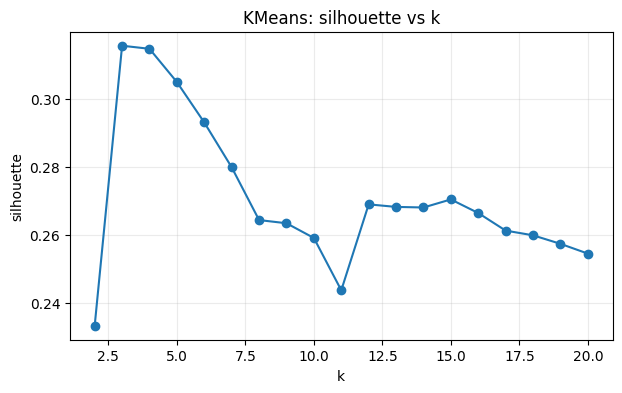

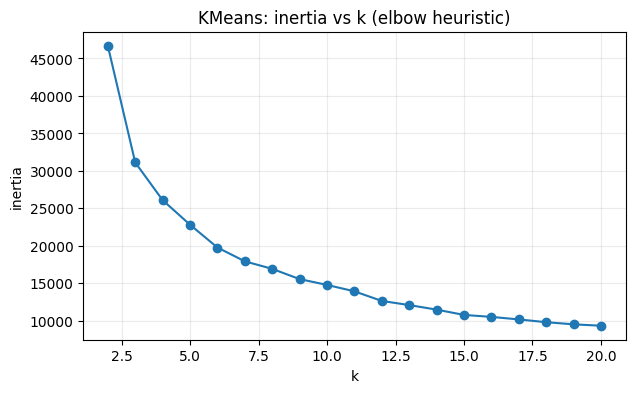

In [18]:
# Быстрый график silhouette по k (если silhouette считалась)
ks = [r["params"]["k"] for r in kmeans_results]
sil = [r["metrics"]["silhouette"] if r["metrics"] else None for r in kmeans_results]

plt.figure(figsize=(7, 4))
plt.plot(ks, sil, marker="o")
plt.title("KMeans: silhouette vs k")
plt.xlabel("k")
plt.ylabel("silhouette")
plt.grid(True, alpha=0.25)
plt.savefig(FIGURES_DIR / "ds3_kmeans_silhouette_vs_k.png")
plt.show()

# Инерция (elbow) – как эвристика
inertia = [r["inertia"] for r in kmeans_results]
plt.figure(figsize=(7, 4))
plt.plot(ks, inertia, marker="o")
plt.title("KMeans: inertia vs k (elbow heuristic)")
plt.xlabel("k")
plt.ylabel("inertia")
plt.grid(True, alpha=0.25)
plt.savefig(FIGURES_DIR / "ds3_kmeans_inertia_vs_k.png")
plt.show()

In [19]:
best_kmeans, best_kmeans_s = pick_best_by_silhouette(kmeans_results)
best_kmeans["params"], round(best_kmeans_s, 3)
best_metrics.append({'dataset3 kmeans': best_kmeans["metrics"]})
best_configs.append({'dataset3 kmeans': best_kmeans["params"]})

In [23]:
# Сетка для DBSCAN: eps и min_samples
# eps зависит от масштаба данных – после scaling обычно eps ~ 0.5..5 (но это очень примерно).
dbscan_eps = [0.1, 0.3, 0.5]
dbscan_min_samples = [3, 5, 10]

dbscan_results = eval_dbscan_grid(X_feat, dbscan_eps, dbscan_min_samples)
len(dbscan_results)

KeyboardInterrupt: 

In [24]:
# Посмотрим, какие варианты вообще дали >=2 кластера (без шума) и посчитали silhouette
valid = [r for r in dbscan_results if r["metrics"] is not None and r["metrics"]["silhouette"] is not None]
print("Valid DBSCAN configs:", len(valid))

# Сортировка по silhouette
valid_sorted = sorted(valid, key=lambda r: r["metrics"]["silhouette"], reverse=True)
for r in valid_sorted[:8]:
    print(r["params"], "sil=", round(r["metrics"]["silhouette"], 3), "noise=", round(r["noise_frac"], 3), "clusters=", r["n_clusters"])


Valid DBSCAN configs: 9
{'eps': 0.1, 'min_samples': 10} sil= 0.812 noise= 0.996 clusters= 5
{'eps': 0.1, 'min_samples': 5} sil= 0.262 noise= 0.912 clusters= 110
{'eps': 0.5, 'min_samples': 10} sil= 0.142 noise= 0.032 clusters= 2
{'eps': 0.1, 'min_samples': 3} sil= 0.115 noise= 0.796 clusters= 409
{'eps': 0.3, 'min_samples': 10} sil= 0.038 noise= 0.216 clusters= 8
{'eps': 0.5, 'min_samples': 5} sil= -0.104 noise= 0.022 clusters= 4
{'eps': 0.5, 'min_samples': 3} sil= -0.232 noise= 0.016 clusters= 12
{'eps': 0.3, 'min_samples': 5} sil= -0.236 noise= 0.125 clusters= 22


In [25]:
best_dbscan = valid_sorted[0] if valid_sorted else None
if best_dbscan:
  print(best_dbscan)

  best_metrics.append({'dataset1 dbscan': best_dbscan["metrics"], "noise_frac": best_dbscan["noise_frac"]})
  best_configs.append({'dataset1 dbscan': best_dbscan["params"]})

{'algo': 'dbscan', 'params': {'eps': 0.1, 'min_samples': 10}, 'labels': array([-1, -1, -1, ..., -1, -1, -1]), 'metrics': {'silhouette': 0.8121356112341516, 'davies_bouldin': 0.2449468669104998, 'calinski_harabasz': 3564.0210417705125}, 'inertia': None, 'n_clusters': 5, 'noise_frac': 0.9959333333333333, 'n_non_noise': 61}


In [26]:
print_result_card("BEST KMEANS (by silhouette)", best_kmeans)
if best_dbscan is not None:
    print_result_card("BEST DBSCAN (by silhouette among valid)", best_dbscan)


NameError: name 'print_result_card' is not defined

Визуализация выбранных решений в 2D

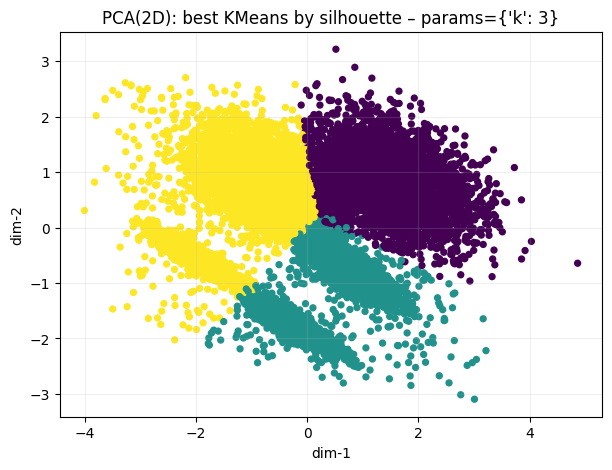

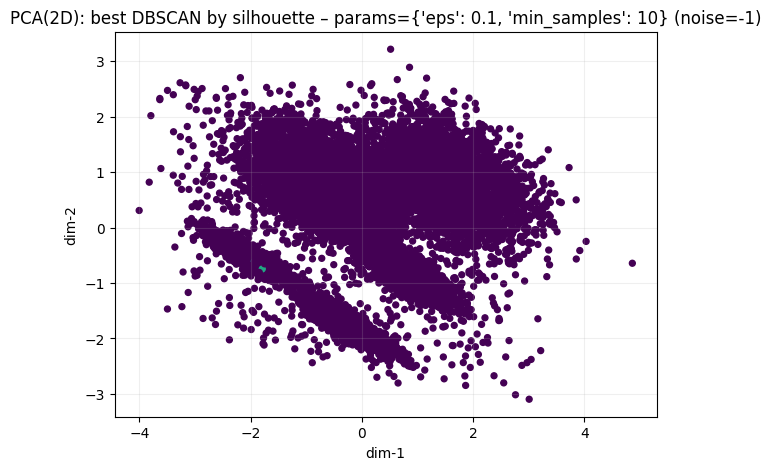

In [27]:
X_plot2d = pca_2d_for_plot(X_scaled, random_state=RANDOM_STATE)

save_path = FIGURES_DIR / "ds1_PCA.png"
# KMeans best
plot_2d_embedding(
    X_plot2d, best_kmeans["labels"],
    title=f"PCA(2D): best KMeans by silhouette – params={best_kmeans['params']}",
    save_path=save_path
)

# DBSCAN best (if exists)
if best_dbscan is not None:
    plot_2d_embedding(
        X_plot2d, best_dbscan["labels"],
        title=f"PCA(2D): best DBSCAN by silhouette – params={best_dbscan['params']} (noise=-1)"
    )

In [ ]:
result_df = pd.DataFrame({
    'sample_id': sample_id,
    'cluster_label': best_kmeans['labels']
})

save_label_path = LABELS_DIR / 'labels_ds3.csv'
result_df.to_csv(save_label_path, index=False)

KMeans отработал неплохо, разделил на 3 кластера.
DBSCAN опять слишком много кластеров и много шума.